# Kickstarter Projects: Success or Bust?

Kickstarter is an online platform where users can help bring “creative projects to life” by donating to projects as they wish. As of 2019, there have been 445,000 projects in categories ranging from music, video games, stage shows and technology. Kickstarter allows unique projects and personal dreams to come into fruition. However, many projects do not get completed and donors can feel like they wasted their money. 


**Objective:** Utilize past data to predict whether a Kickstarter project will meet its initial donation goal.

1. Data Cleaning
    * Null values
    * Erroneous Values
2. Exploratory Data Analysis
    * Visualizing dataset
    * Correlations    
3. Data Preprocessing
    * Scale numerical features
    * One-hot encode categorical features
    * train_test_split dataset    
4. **Modeling**
    * **Decision Tree/Random Forest Classifiers**
    * **Gradient Boosting Classifier**
    * **K-Nearest Neighbors Classifier**
    * **Hyperparameter Tuning**

This project uses the dataset from the Kaggle dataset "Kickstarter Projects" found [here.](https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv)

### Import necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree, metrics

In [2]:
X_train = pd.read_csv('data/train_test/X_train.csv',index_col = 0)
X_test = pd.read_csv('data/train_test/X_test.csv', index_col = 0)
y_train = pd.read_csv('data/train_test/y_train.csv', index_col = 0)
y_test = pd.read_csv('data/train_test/y_test.csv', index_col = 0)

In [3]:
display(X_train.head(), y_train.head())

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,days_until_deadline,main_category_Art,main_category_Comics,main_category_Crafts,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
267583,-1.423389,0.379816,0.365343,0.496911,0.382354,-1.440397,-0.241498,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30421,-1.225194,0.408290,0.009492,0.524899,0.410896,-1.239136,-0.154425,0,0,0,...,0,0,0,0,0,0,0,0,0,1
312140,-0.235538,0.831170,0.665675,0.940554,0.834773,-0.234173,0.584453,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49853,1.400252,0.027494,-0.172813,0.069640,0.029201,1.426918,0.886965,0,0,0,...,0,0,0,0,0,0,0,0,0,1
89312,0.582313,0.363468,0.009492,0.480842,0.365968,0.596328,1.538770,1,0,0,...,0,0,0,0,0,0,0,0,0,1


,state
267583,1
30421,1
312140,1
49853,0
89312,0


### 0. Naive Classifier

Baseline score using Naive Classifier (all predictions are 1)
Accuracy: 0.3579
Balanced Accuracy: 0.5000
Precision score for yes: 0.3579
Recall score for yes: 1.0000


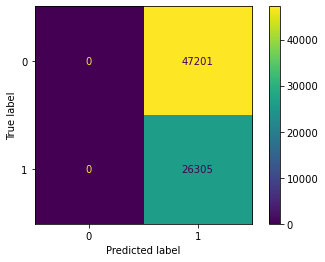

In [30]:
naive = [1]*len(y_test)
naive_cm = metrics.confusion_matrix(y_test, naive)

acc = metrics.accuracy_score(y_test, naive)
bal_acc = metrics.balanced_accuracy_score(y_test, naive)
precision = metrics.precision_score(y_test, naive, pos_label = 1)
recall = metrics.recall_score(y_test, naive, pos_label = 1)

print('Baseline score using Naive Classifier (all predictions are 1)')
print(f'Accuracy: {acc:.4f}')
print(f'Balanced Accuracy: {bal_acc:.4f}')
print(f'Precision score for yes: {precision:.4f}')
print(f'Recall score for yes: {recall:.4f}')

disp = metrics.ConfusionMatrixDisplay(confusion_matrix = naive_cm)
disp.plot()
plt.show()

### 1. Decision Tree Classifier

In [5]:
baseline = tree.DecisionTreeClassifier(criterion = 'entropy')
baseline.fit(X_train, y_train)

baseline_pred = baseline.predict(X_test)

In [6]:
def score_model(model, prediction):
    acc = metrics.accuracy_score(y_test, prediction)
    bal_acc = metrics.balanced_accuracy_score(y_test, prediction)
    precision = metrics.precision_score(y_test, prediction, pos_label = 1)
    recall = metrics.recall_score(y_test, prediction, pos_label = 1)
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'Precision score for yes: {precision:.4f}')
    print(f'Recall score for yes: {recall:.4f}')
    
    class_labels = model.classes_.astype(str)
    
    print(metrics.classification_report(y_test, prediction))
    
    metrics.plot_confusion_matrix(model, X_test, y_test, display_labels = class_labels)
    plt.show()
    
    return

Baseline Decision Tree Model
Accuracy: 0.9950
Balanced Accuracy: 0.9944
Precision score for yes: 0.9934
Recall score for yes: 0.9925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47201
           1       0.99      0.99      0.99     26305

    accuracy                           0.99     73506
   macro avg       0.99      0.99      0.99     73506
weighted avg       0.99      0.99      0.99     73506



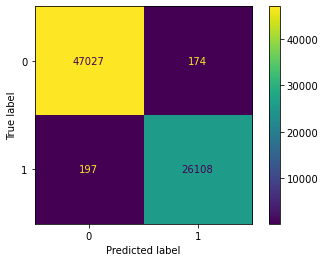

In [7]:
print("Baseline Decision Tree Model")
score_model(baseline, baseline_pred)

From the baseline Decision Tree model, we are able to accurately predict whether Kickstarter projects will reach their goal or not. However, with such good results, it seems like this could be too good to be true. To make sure, I will try hyperparameter tuning and other models to further optimize the model.

In [8]:
baseline.get_depth()

34

### 1a. Hyperparameter Tuning for Decision Tree

In [9]:
from sklearn.model_selection import RandomizedSearchCV

def tune_model(model, param_grid):
    model_randomsearch = RandomizedSearchCV(model, param_grid, cv = 5)
    
    model_randomsearch.fit(X_train, y_train.values.ravel())
    
    print(f'Optimal hyperparameters: {model_randomsearch.best_params_}')
    
    tuned_pred = model_randomsearch.predict(X_test)
    
    return model_randomsearch, tuned_pred

In [10]:
params = {'max_depth': [10,20,30,40, None],
          'criterion': ['gini', 'entropy'],
          'max_features': np.arange(1,10)}

clf = tree.DecisionTreeClassifier()

tree_cv, tree_cv_pred = tune_model(clf, params)

Optimal hyperparameters: {'max_features': 7, 'max_depth': 30, 'criterion': 'gini'}


Hyperparameter Tuned Decision Tree Model
Accuracy: 0.9905
Balanced Accuracy: 0.9899
Precision score for yes: 0.9860
Recall score for yes: 0.9876
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     47201
           1       0.99      0.99      0.99     26305

    accuracy                           0.99     73506
   macro avg       0.99      0.99      0.99     73506
weighted avg       0.99      0.99      0.99     73506



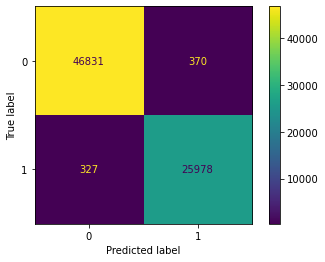

In [11]:
print('Hyperparameter Tuned Decision Tree Model')
score_model(tree_cv, tree_cv_pred)

Using `RandomizedSearchCV` only performed slightly worse than the baseline model. The results are still outstanding for a classifier, scoring 0.9939 and 0.9940 for precision and recall, respectively. 

### 2. Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

base_forest = RandomForestClassifier(n_estimators = 300, n_jobs = -1)
base_forest.fit(X_train, y_train.values.ravel())

base_forest_pred = base_forest.predict(X_test)

Base Random Forest Model
Accuracy: 0.9962
Balanced Accuracy: 0.9970
Precision score for yes: 0.9899
Recall score for yes: 0.9996
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     47201
           1       0.99      1.00      0.99     26305

    accuracy                           1.00     73506
   macro avg       0.99      1.00      1.00     73506
weighted avg       1.00      1.00      1.00     73506



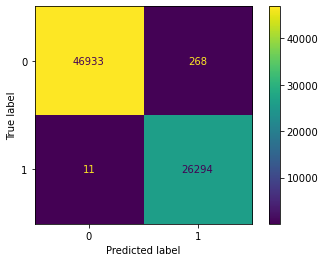

In [13]:
print('Base Random Forest Model')
score_model(base_forest, base_forest_pred)

The baseline Random Forest model performed significantly better than the past two decision tree models which was expected, as a Random Forest is an ensemble of multiple Decision Trees working simultaneously. Because this model is already performing extremely well, this model will stay as is without hyperparameter tuning.

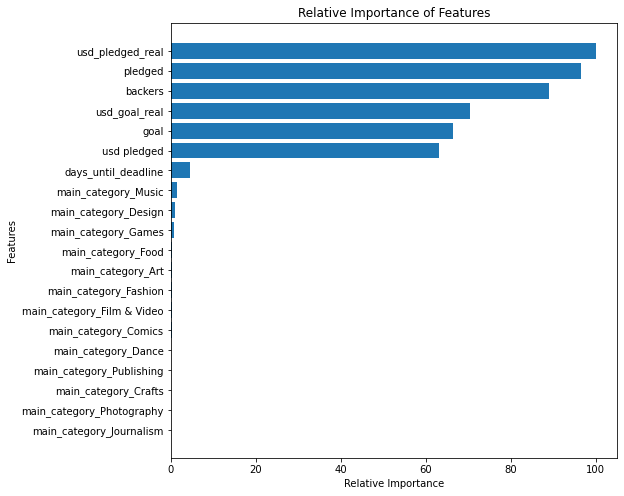

In [14]:
feature_importance = base_forest.feature_importances_
feature_importance = 100*(feature_importance / max(feature_importance))[:20]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (8,8))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.title('Relative Importance of Features')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

From the graph above, it can be seen that the most important feature in terms of predicting whether the project's goal will be met is `percent_achieved_real`. This makes sense as the higher the percent is, the more likely the project goal will be achieved, and vice versa. No other feature has a strong of a correlation as `percent_achieved_real`. After the 8th most important feature, the features are the one hot encoded main category features with almost 0 relative importance. This means that the main category of a Kickstarter project has minimal impact on how this model made its predictions. 

### 3. Gradient Boosting Classifier

Accuracy: 0.9894
Balanced Accuracy: 0.9915
Precision score for yes: 0.9718
Recall score for yes: 0.9992
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     47201
           1       0.97      1.00      0.99     26305

    accuracy                           0.99     73506
   macro avg       0.99      0.99      0.99     73506
weighted avg       0.99      0.99      0.99     73506



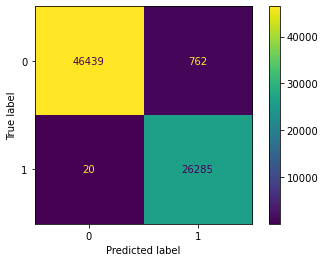

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

base_gbm = GradientBoostingClassifier()
base_gbm.fit(X_train, y_train.values.ravel())

base_gbm_pred = base_gbm.predict(X_test)

score_model(base_gbm, base_gbm_pred)

### 3a. Hyperparameter Tuning for Gradient Boosting Classifier

In [16]:
params = {'learning_rate': np.arange(0.05,0.2,0.05),
          'n_estimators': np.arange(20,81,10)}

gbm = GradientBoostingClassifier()

gbm_cv, gbm_cv_pred = tune_model(gbm, params)

Optimal hyperparameters: {'n_estimators': 80, 'learning_rate': 0.2}


Hyperparameter Tuned Gradient Boosting Classifier
Accuracy: 0.9923
Balanced Accuracy: 0.9938
Precision score for yes: 0.9795
Recall score for yes: 0.9993
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     47201
           1       0.98      1.00      0.99     26305

    accuracy                           0.99     73506
   macro avg       0.99      0.99      0.99     73506
weighted avg       0.99      0.99      0.99     73506



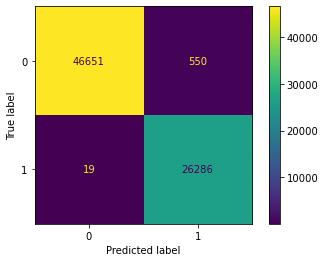

In [17]:
print('Hyperparameter Tuned Gradient Boosting Classifier')
score_model(gbm_cv, gbm_cv_pred)

Tuning the hyperparameters of the Gradient Boosting Machine classifier resulted in only a slight improvement of its predicting power. There are still as many incorrectly predicted 0 labels but was able to correctly predict all projects that have met their goal. With the tuned hyperparameters, the Gradient Boosting classifier is the best performing model so far, even if it's by only an incremental amount.

### 4. K-Nearest Neighbors Classifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []

for i in range(1,11):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train.values.ravel())
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
    

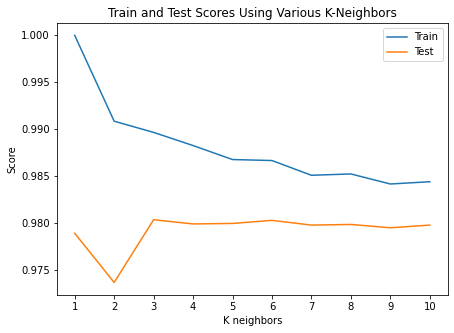

In [19]:
plt.figure(figsize = (7,5))
plt.plot(range(1,11), train_scores, label = 'Train')
plt.plot(range(1,11), test_scores, label = 'Test')
plt.xticks(range(1,11))
plt.xlabel('K neighbors')
plt.ylabel('Score')
plt.title('Train and Test Scores Using Various K-Neighbors')
plt.legend()
plt.show()

K-Nearest Neighbors Classifier
Accuracy: 0.9804
Balanced Accuracy: 0.9813
Precision score for yes: 0.9615
Recall score for yes: 0.9846
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     47201
           1       0.96      0.98      0.97     26305

    accuracy                           0.98     73506
   macro avg       0.98      0.98      0.98     73506
weighted avg       0.98      0.98      0.98     73506



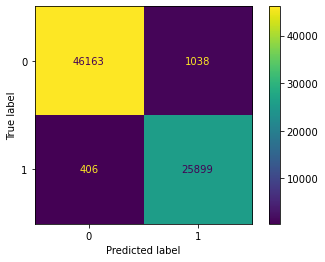

In [20]:
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train.values.ravel())

knn_pred = knn.predict(X_test)

print('K-Nearest Neighbors Classifier')
score_model(knn, knn_pred)

At a $K$ value of 3, the imporvement on training set score decreased and so $K=3$ was used to predict outcomes on the test set. Although the model objectively did well, the previous models have performed far better than the K-Nearest Neighbors classifier. 

### 5. ROC Curve

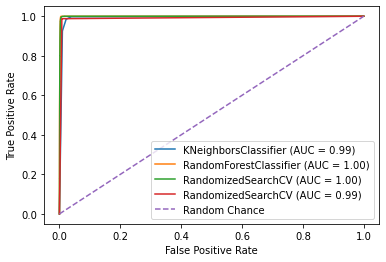

In [21]:
ax = plt.gca()
knn_roc = metrics.plot_roc_curve(knn, X_test, y_test, ax = ax)
forest_roc = metrics.plot_roc_curve(base_forest, X_test, y_test, ax = ax)
gbm_roc = metrics.plot_roc_curve(gbm_cv, X_test, y_test, ax = ax)
tree_roc = metrics.plot_roc_curve(tree_cv, X_test, y_test, ax = ax)
plt.plot([0,1], [0,1], linestyle = '--', label = 'Random Chance')
plt.legend()
plt.show()

With a perfect recall score, from the tests done above, the hyperparameter tuned gradient boosting classifier performed the best out of all models. To properly predict whether a Kickstarter's goal will be met or not, the gradient boosting model will be used. 